In [1]:
pip install sounddevice

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install soundfile

Note: you may need to restart the kernel to use updated packages.


In [3]:
import sounddevice as sd
import soundfile as sf
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, rfft, irfft
from scipy.fft import idct
from scipy.fft import dct
from scipy import signal
from scipy.signal import convolve

In [4]:
'''
HELPER FUNCTIONS:DO NOT MODIFY
'''


'''
save_audio
INPUT:
    -filename: String that contains the path (optional) and name of the file you want to save.
    -data: Numpy array containing the sampled signal in discrete-time domain.
    -Fs: Sampling frequency.
OUTPUT:
    -A '.wav' file 
'''

def save_audio(filename, data, Fs):
    
    if filename[-4:]!='.wav':
        filename = filename + '.wav'
    
    sf.write(filename, data, Fs)
    
'''
generate_sine_wave
INPUT:
    -student: String containing student number-
    -duration: Integer indicating the desired signal duration in seconds.
    -sample_rate: sampling frequency
    
OUTPUT:
    -y_normalized_noisy: Numpy array containing the noisy recorded signal in discrete-time domain.
    
'''

def generate_recorded_signal(student, duration, sample_rate):
    
    freq = int(str(abs(hash(student)))[:3])
    freq_noisy = int(str(abs(hash(student)))[:4])
            
    x = np.linspace(0, duration, sample_rate * duration, endpoint=False)
    
    frequencies = x * freq
    frequencies_noisy = x * freq_noisy
    
    y = np.sin((2 * np.pi) * frequencies)
    y_noisy = np.sin((2 * np.pi) * frequencies_noisy)
    
    y_noisy = y_noisy * 0.3

    y_mixed = y + y_noisy
    y_normalized_noisy = np.int16((y_mixed / y_mixed.max()) * 32767)
    
    return y_normalized_noisy

#  Exercise 1: Filtering of an Audio Signal


1. Design an analogue anti-aliasing Butterworth low-pass filter that ensures as much of the signal content as possible is preserved, while avoiding aliasing after discretization with a sampling frequency $F_s = 44.1$kHz. You can use `scipy.signal.butter` function with the appropriate arguments. Provide the filter coefficients and the plot of the filter transfer function.

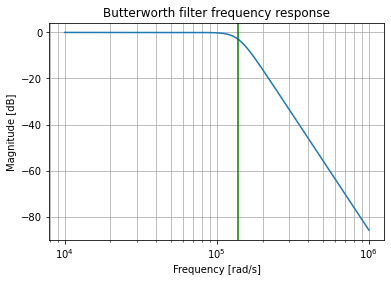

In [5]:
Fs = 44100

## Add your code here
#cut off frequency Fc < Fs
Fc = Fs/2
Wc = Fc*2*np.pi

# filter order
# choosing a high order lowpass butterworth filter to get a sharp roll-off of the high frequency
order = 5

# 1th-order analog Butterworth filter
# getting the filter's coefficients with signal.butter
b, a = signal.butter(order, Wc, 'lowpass', Fs)

# Calculate frequency response
w, h = signal.freqs(b, a)

# Plot frequency response
fig1, ax1 = plt.subplots()
ax1.semilogx(w, 20 * np.log10(np.abs(h)))
plt.title('Butterworth filter frequency response')
plt.xlabel('Frequency [rad/s]')
plt.ylabel('Magnitude [dB]')
plt.axvline(Wc, color='green')
ax1.grid(which='both', axis='both')
ax1.axis('tight')
plt.show()

2.1. To generate the noisy discretized signal $x_r[n]$ (denoted with `noisy_tone` in the code) for your student group, run the cell below with the string variable `student_id` equal to your student number value (in case you are a group of more students, you can use any of your student numbers). 

In [6]:
DURATION = 5
student_id = '20929519' #substitute with your student number
noisy_tone = generate_recorded_signal(student_id, DURATION, Fs)
save_audio("noisy", noisy_tone, Fs)

2.2. `noisy_tone` is the signal that was obtained after recording  an original audio signal in the presence of electric hum of unknown frequency. Compute its frequency spectrum and plot it. Based on the plot, identify the frequency of the noise. You can assume that the noise is only present at a single frequency and that its amplitude is smaller than the amplitude of the original signal.

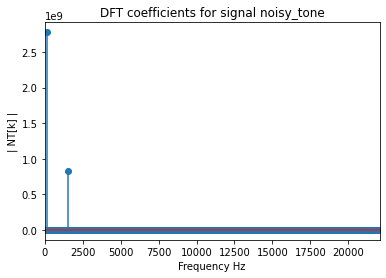

Frequency of electric hum:  1544.0  Mirrored frequency:  42556.0


In [7]:
## Add your code here
# calculate the DFT of noisy_tone
NT = fft(noisy_tone)

# Define indices and ranges
k = np.arange(0,len(noisy_tone))
freq = (k*Fs)/len(NT)

# Plot the magnitude of DFT
plt.stem(freq, np.abs(NT), use_line_collection=True)
plt.xlim([0, Fs/2]) # everything that comes after pi are the mirrored values
plt.ylabel('| NT[k] |')
plt.xlabel('Frequency Hz')
plt.title('DFT coefficients for signal noisy_tone')
plt.show()

# find the frequency of the electric hum which lies between 0.5e9 and 1e9 according to the plot
# also we see that there are only two |NT[k]| that satisfy the above condition
# Ω = wTs for small Ω
freq_electric_hum = np.array([0,0], dtype=float)
counter = 0
for i in range(0, len(NT)):
    if np.abs(NT[i]) > 0.5e9 and np.abs(NT[i]) < 1e9:
        freq_electric_hum[counter] = freq[i]
        counter += 1
        if counter > 1:
            break
print('Frequency of electric hum: ', freq_electric_hum[0], ' Mirrored frequency: ', freq_electric_hum[1])

3.1. Filter out the identified noise by setting the corresponding coefficient in the spectrum to zero. Once you do this, plot the spectrum and time-domain representation of the filtered signal. 

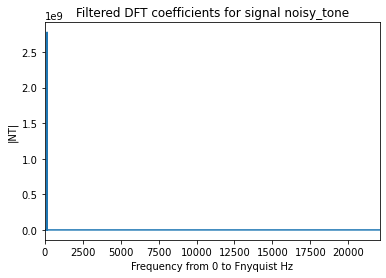

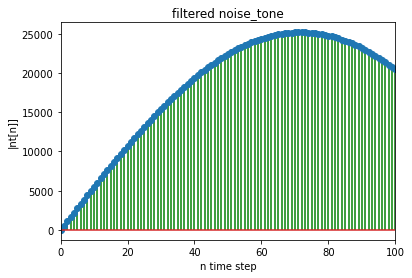

In [8]:
## Add your code here
# setting the corresponding coefficient for the electric hum to zero
for i in range(0, len(NT)):
    if np.abs(NT[i]) > 0.5e9 and np.abs(NT[i]) < 1e9:
        NT[i] = 0

k = np.arange(0, len(NT))
freq = (k*Fs)/len(NT)

# plotting the frequency spectrum of the filtered signal
plt.plot(freq, np.abs(NT))
plt.ylabel('|NT|')
plt.xlabel('Frequency from 0 to Fnyquist Hz')
plt.title('Filtered DFT coefficients for signal noisy_tone')
plt.xlim([0, Fs/2])
plt.show()

# plotting the time domain representation of the filtered signal
section = 100 # choose xlim range small to be able to see the effect
nt = ifft(NT)
n = np.arange(0, len(nt))
plt.stem(n, np.abs(nt),'g', use_line_collection=True)
plt.title('filtered noise_tone')
plt.xlabel('n time step')
plt.ylabel('|nt[n]]')
plt.xlim([0, section])
plt.show()

3.2. To check if you correctly cancelled the noise, also plot your results against the original noisy function (on the same plot), both in time and frequency domain. You can use the helper function `save_audio()` to save the audio file corresponding to the filtered signal.

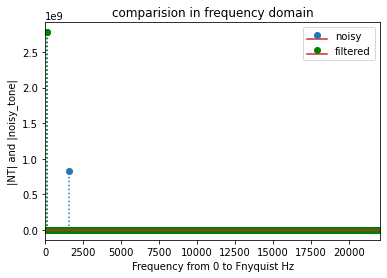

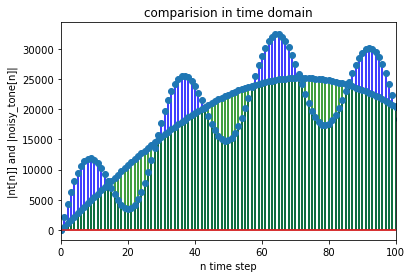

In [9]:
## Add your code here
# plot comparision in frequency domain
markerline, stemlines, baseline = plt.stem(freq, np.abs(fft(noisy_tone)), markerfmt='o', use_line_collection=True, label='noisy')
plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
plt.setp(stemlines, 'linestyle', 'dotted')


markerline, stemlines, baseline = plt.stem(freq, np.abs(NT), markerfmt='go', use_line_collection=True, label='filtered')
plt.setp(stemlines, 'color', plt.getp(markerline, 'color'))
plt.setp(stemlines, 'linestyle', 'dotted')

plt.legend()
plt.ylabel('|NT| and |noisy_tone|')
plt.xlabel('Frequency from 0 to Fnyquist Hz')
plt.title('comparision in frequency domain')
plt.xlim([0, Fs/2])
plt.show()

# plot comparision in time domain
section = 100 # choose xlim range small to be able to see the effect
nt = ifft(NT)
n = np.arange(0, len(nt))
plt.stem(n, np.abs(noisy_tone), 'b', use_line_collection=True, label='noisy')
plt.stem(n, np.abs(nt),'g', use_line_collection=True, label='filtered')
plt.title('comparision in time domain')
plt.xlabel('n time step')
plt.ylabel('|nt[n]] and |noisy_tone[n]|')
plt.xlim([0, section])
plt.show()

save_audio(data=np.real(nt), Fs=Fs, filename='Filter_Audio')

4. Compare the anti-aliasing filter you designed in 1 and the frequency-domain filtering from 3. In particular, contrast them in terms of causality and of what you can say regarding their benefits and drawbacks.


### Answer:
The anti-aliasing filter that was designed in 1 and the frequency-domain filtering from 3 are both methods used to eliminate unwanted frequency components in a signal, but they differ in how they achieve this goal.

The anti-aliasing filter is designed to eliminate high-frequency content that would cause aliasing when downsampling a signal, by attenuating the frequency components above a certain cutoff frequency. This filter is applied before the signal is downsampled, and it's a linear and time-invariant system, meaning that it does not depend on the past or future input and the output is only a function of the current input. This filter is causal, meaning that the output only depends on the current and previous inputs.

On the other hand, the frequency-domain filtering from 3 is designed to eliminate a specific frequency component of noise that is present in the signal after it has been recorded. This is done by identifying the frequency of the noise and setting the corresponding spectral coefficient to zero in the frequency domain representation of the signal. This filter is applied after the signal has been recorded, and it's also a linear and time-invariant system. However, it's not a causal filter, meaning that it can't be implemented in real-time and it's not dependent on the current input only, it's dependent on the whole signal.

In terms of benefits and drawbacks, the anti-aliasing filter is beneficial for preventing aliasing when downsampling a signal and ensuring that the signal is accurately represented after downsampling. However, it can result in a loss of high-frequency information and a reduction in the overall signal-to-noise ratio. On the other hand, the frequency-domain filtering is beneficial for removing specific unwanted frequency components in a signal, such as noise, and it can be a powerful tool for signal denoising. However, it's not a real-time process, and it's dependent on the whole signal, which can cause a delay in the output.

In summary, the anti-aliasing filter is used to prevent aliasing and preserve signal quality when downsampling while frequency-domain filtering is used to remove specific unwanted frequency components from the signal, such as noise, after it has been recorded. The anti-aliasing filter is causal, linear and time-invariant, but it can result in a loss of high-frequency information, while the frequency-domain filtering is non-causal, linear and time-invariant but it's not a real-time process and it's dependent on the whole signal.